## Seminar - ML + SoC 
### Based on the training "From Algorithm to Hardware: Machine Learning in Embedded Systems"

##### San Luis, Argentina - 2025

-------

## High-Level Synthesis for Machine Learning (hls4ml)


💡 **High-Level Synthesis for Machine Learning (hls4ml)**  is an open-source library that transforms machine learning models into hardware descriptions optimized for FPGA deployment.

**Key Features of hls4ml:** 

- Converts models from Keras, TensorFlow, PyTorch, and ONNX into High-Level Synthesis (HLS) projects.

- Utilizes tools like Xilinx Vitis HLS and Intel HLS Compiler to generate optimized C++ code for hardware implementation.

- Enhances efficiency by reducing latency and power consumption, making it ideal for AI applications in edge computing.

- Supports quantization and pruning techniques to shrink model size while maintaining accuracy.


For further details:

- GitHub: https://github.com/fastmachinelearning/hls4ml

- Web site: https://fastmachinelearning.org/hls4ml/

---

### Librerías

In [1]:
import os
import numpy as np
import tensorflow as tf 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from qkeras import *
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm
import hls4ml
import matplotlib.pyplot as plt


2025-04-14 20:27:18.972028: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/tools/anaconda3/envs/neuralEnv/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tools/anaconda3/envs/neuralEnv/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'


### Path a Vitis HLS


Como paso inicial se debe especificar el directorio de instalación de Vivado HLS o Vitis HLS. 

In [2]:
# Path donde se encuentra instalado Vitis HLS!! 

os.environ['PATH'] = '/tools/Xilinx/XilinxUnified_2022/Vitis_HLS/2022.2/bin:' + os.environ['PATH']

# Para MÁQUINA VIRTUAL!
os.environ['PATH'] = '/tools/Xilinx/Vitis_HLS/2022.2/bin:' + os.environ['PATH']
os.environ['PATH']



'/tools/Xilinx/Vitis_HLS/2022.2/bin:/tools/Xilinx/XilinxUnified_2022/Vitis_HLS/2022.2/bin:/tools/anaconda3/envs/neuralEnv/bin:/tools/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin'

#### Load the model (.h5)

In [3]:

from qkeras.utils import _add_supported_quantized_objects
co = {}
_add_supported_quantized_objects(co)
model = load_model('models/mnistQAP.h5', custom_objects=co)
    

model.summary()


2025-04-14 20:27:22.909568: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-04-14 20:27:22.910173: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-04-14 20:27:23.003373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-14 20:27:23.003543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 with Max-Q Design computeCapability: 7.5
coreClock: 1.155GHz coreCount: 14 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 149.04GiB/s
2025-04-14 20:27:23.003570: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-04-14 20:27:23.004981: I tensorflow/stream_ex

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1_input (QDense)           (None, 5)                 3925      
_________________________________________________________________
relu_input (QActivation)     (None, 5)                 0         
_________________________________________________________________
fc1 (QDense)                 (None, 7)                 42        
_________________________________________________________________
relu1 (QActivation)          (None, 7)                 0         
_________________________________________________________________
fc2 (QDense)                 (None, 10)                80        
_________________________________________________________________
relu2 (QActivation)          (None, 10)                0         
_________________________________________________________________
output (QDense)              (None, 2)                 2

#### Weight distribution

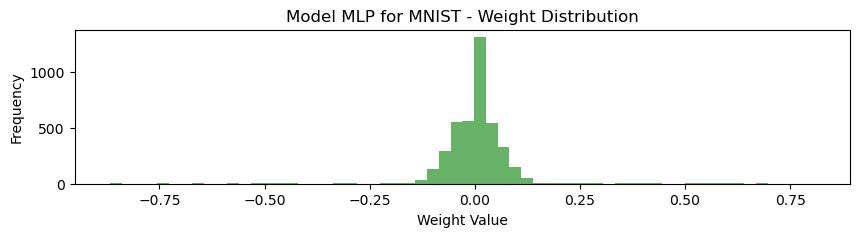

In [4]:
# Weight distribution

weights = np.concatenate([w.flatten() for w in model.get_weights()])

plt.figure(figsize=(10,2))
plt.hist(weights, bins=60, color='green', alpha=0.6)
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.title("Model MLP for MNIST - Weight Distribution")
plt.show()


### high-Level Synthesis for Machine Learning (hls4ml )

hls configuration

In [6]:
hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'])
hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(rounding_mode='AP_RND')
hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(saturation_mode='AP_SAT')


hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

import plotting

print("-----------------------------------")
plotting.print_dict(hls_config)
print("-----------------------------------")




Interpreting Sequential
Topology:
Layer name: fc1_input_input, layer type: InputLayer, input shapes: [[None, 784]], output shape: [None, 784]
Layer name: fc1_input, layer type: QDense, input shapes: [[None, 784]], output shape: [None, 5]
Layer name: relu_input, layer type: Activation, input shapes: [[None, 5]], output shape: [None, 5]
Layer name: fc1, layer type: QDense, input shapes: [[None, 5]], output shape: [None, 7]
Layer name: relu1, layer type: Activation, input shapes: [[None, 7]], output shape: [None, 7]
Layer name: fc2, layer type: QDense, input shapes: [[None, 7]], output shape: [None, 10]
Layer name: relu2, layer type: Activation, input shapes: [[None, 10]], output shape: [None, 10]
Layer name: output, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 2]
Layer name: sigmoid, layer type: Activation, input shapes: [[None, 2]], output shape: [None, 2]
-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy

In [7]:
for layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][layer]['Trace'] = True
    hls_config['LayerName'][layer]['ReuseFactor'] = 16

hls_config['LayerName']['fc1_input_input']['Precision'] = 'ap_fixed<16, 6>'   
hls_config['LayerName']['sigmoid']['Strategy'] = 'Stable'


### hls4ml with Vitis HLS as backend

In [8]:
cfg = hls4ml.converters.create_config(backend='vitis')

# cfg['IOType']     = 'io_stream'   # Must set this if using CNNs!
cfg['HLSConfig']  = hls_config      # HLS configuraiton
cfg['KerasModel'] = model           # Keras model to be converted
cfg['OutputDir']  = 'hls4ml/'       # Project name
cfg['Part'] = 'xc7z020clg484-1'     # PYNQ-Z1 or Zedboard: xc7z020clg484-1  ARTIX-7 xc7a35tcsg325-1  # MPSoC xczu4eg-sfvc784-2-e  xczu3eg-sfvc784-1-e


hls_model = hls4ml.converters.keras_to_hls(cfg)

Interpreting Sequential
Topology:
Layer name: fc1_input_input, layer type: InputLayer, input shapes: [[None, 784]], output shape: [None, 784]
Layer name: fc1_input, layer type: QDense, input shapes: [[None, 784]], output shape: [None, 5]
Layer name: relu_input, layer type: Activation, input shapes: [[None, 5]], output shape: [None, 5]
Layer name: fc1, layer type: QDense, input shapes: [[None, 5]], output shape: [None, 7]
Layer name: relu1, layer type: Activation, input shapes: [[None, 7]], output shape: [None, 7]
Layer name: fc2, layer type: QDense, input shapes: [[None, 7]], output shape: [None, 10]
Layer name: relu2, layer type: Activation, input shapes: [[None, 10]], output shape: [None, 10]
Layer name: output, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 2]
Layer name: sigmoid, layer type: Activation, input shapes: [[None, 2]], output shape: [None, 2]
Creating HLS model


In [9]:
hls_model.compile()

Writing HLS project
Done


#### Hardware synthesis

In [10]:
hls_model.build(csim=False, export=False)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2022.2 (64-bit)
  **** SW Build 3670227 on Oct 13 2022
  **** IP Build 3669848 on Fri Oct 14 08:30:02 MDT 2022
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/XilinxUnified_2022/Vitis_HLS/2022.2/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/XilinxUnified_2022/Vitis_HLS/2022.2/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'ro' on host 'mareKaleido' (Linux_x86_64 version 5.15.0-136-generic) on Mon Apr 14 20:27:56 CEST 2025
INFO: [HLS 200-10] On os Ubuntu 20.04.6 LTS
INFO: [HLS 200-10] In directory '/home/ro/kaleido/repo/seminar-ML-FPGA-SanLuis2025/hands-on/hls4ml'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Creating and opening project '/home/ro/kaleido/repo/seminar-ML-FPGA-SanLuis2025/hands-on/hls4ml/myproject_prj'.
INFO: [HLS 200-1510] Running: set_top myproject 
INFO: [HLS 

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.302',
  'BestLatency': '26',
  'WorstLatency': '26',
  'IntervalMin': '8',
  'IntervalMax': '8',
  'BRAM_18K': '1',
  'DSP': '6',
  'FF': '37553',
  'LUT': '54132',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'}}

---
#### San Luis, Argentina - 2025

Romina Soledad Molina, Ph.D. - MLab/STI ICTP, Trieste, Italy